## Seed Rank Plot
This project measures the gene coverage of optimal, real and random seeds. 

The two Main functions are 'generate_all_count()' and 'plot_seed_rank()'. These two functions are runnable with genome_filename, mature_filename, canon_site, replacement parameters. 

generate_all_count() will count the number of genes covered by a seed. It counts the gene coverage for real, random, and optimal seeds, then ranks the seeds from most covered to least covered. This data is then stored in a file under 'Final Seed Count'. The names of each seed is not recorded.

plot_seed_rank() takes the real, random, and optimal data from 'Final Seed Count' and plots them against each other.

In [2]:
import pandas as pd
from numpy import loadtxt
import time
import os
import random
import numpy as np
import ast
import itertools as it
import matplotlib.font_manager
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as mpatches

In [4]:
species_list = [
    #("octopus_3utr","Common Octopus (Octopus vulgaris)")
    ("Zebrafish genes (GRCz11)_sample(50%)","Zebrafish (Danio rerio)"),
    ("Human genes (GRCh38.p13)_sample(50%)","Human (Homo sapiens)")
]

In [3]:
species_list = [("Octopus bimaculoides (California two-spot octopus, UCB-OBI-ISO-001)","California two-spot octopus (Octopus bimaculoides)")]

In [4]:
def seed_count(seed_list, genome, replacement):
    genome = [*set(genome)]
    seed_count_array = []
    for seed in seed_list:
        count = 0
        cover_list = []
        for gene in genome:
            if seed in gene:
                count+=1
                cover_list.append(gene)
        seed_count_array.append(count)
        if replacement == False:
            genome = [i for i in genome if i not in cover_list]
    return seed_count_array

In [5]:
def count_real_seeds(genome_filename, mature_filename, canon_site, genome, replacement):
    start_time = time.time()
    
    #returns real coverage and seed number from mature data
    df = pd.read_csv("Mature Data/"+mature_filename+'.csv')
    
    #We are ignoring Pre and Post for this project
    real_seeds = df['Seed']
    
    #create reverse compliments
    real_seeds = [sub.replace('A', 'X') for sub in real_seeds]
    real_seeds = [sub.replace('U', 'A') for sub in real_seeds]
    real_seeds = [sub.replace('X', 'T') for sub in real_seeds]
    real_seeds = [sub.replace('C', 'X') for sub in real_seeds]
    real_seeds = [sub.replace('G', 'C') for sub in real_seeds]
    real_seeds = [sub.replace('X', 'G') for sub in real_seeds]
    real_seeds = [sub[::-1] for sub in real_seeds]
    
    #If canon site A or C, append A at the end
    if canon_site == 'A':
        real_seeds = [item[:-1]+'A' for item in real_seeds]
    elif canon_site == 'C':
        real_seeds = [item+'A' for item in real_seeds]
    #remove repeats
    real_seeds = [*set(real_seeds)]
    
    global REAL_SEED_COUNT
    REAL_SEED_COUNT = len(real_seeds)
    
    #generate seed_count
    count_data = seed_count(real_seeds, genome, replacement)
    
    #save data 
    new_file_path = "Final Seed Count/"+genome_filename+"/Canon Site "+canon_site+"/Replacement_"+str(replacement)
    if not os.path.exists(new_file_path):
        os.makedirs(new_file_path)
    with open(new_file_path+"/real.txt", "w") as output:
        output.write(str(count_data))
        
    print("Real done in %s seconds!" % (time.time()-start_time))

In [6]:
def count_optimal_seeds(genome_filename, mature_filename, canon_site, genome, replacement):
    #takes in the optimal_seed_set for a given species and canon_site
    start_time = time.time()
    
    #retrieve optimal seeds
    new_file_path = "Optimal Seed Set/"+genome_filename + " Seed Set/Canon Site "+canon_site+"/"+str(random.randint(0,14))+".txt"
    with open(new_file_path, 'r') as f:
            optimal_seeds = ast.literal_eval(f.read())
    global REAL_SEED_COUNT
    if REAL_SEED_COUNT == -1:
        print("ERROR: You have not retrieved the REAL_SEED_COUNT, run count_real_seeds() first and try again")
        return
    optimal_seeds = optimal_seeds[0:REAL_SEED_COUNT]
    
    #generate seed_count
    count_data = seed_count(optimal_seeds, genome, replacement)
    
    #save data 
    new_file_path = "Final Seed Count/"+genome_filename+"/Canon Site "+canon_site+"/Replacement_"+str(replacement)
    if not os.path.exists(new_file_path):
        os.makedirs(new_file_path)
    with open(new_file_path+"/optimal.txt", "w") as output:
        output.write(str(count_data))
        
    print("Optimal done in %s seconds!" % (time.time()-start_time))

In [7]:
def randSeeds(canon_site, size):
    if canon_site == 'A':
        motif_list = [''.join(i) for i in it.product('AGCT', repeat=6)]
        motif_list = [item + 'A' for item in motif_list]
        sample = random.sample(motif_list,size)
    elif canon_site == 'B':
        motif_list = [''.join(i) for i in it.product('AGCT', repeat=7)]
        sample = random.sample(motif_list,size)
    elif canon_site == 'C':
        motif_list = [''.join(i) for i in it.product('AGCT', repeat=7)]
        motif_list = [item + 'A' for item in motif_list]
        sample = random.sample(motif_list,size)
    return sample

In [8]:
def count_random_seeds(genome_filename, mature_filename, canon_site, genome, replacement):
    #generates random seeds
    start_time = time.time()
    
    #generate random seeds
    global REAL_SEED_COUNT
    if REAL_SEED_COUNT == -1:
        print("ERROR: You have not retrieved the REAL_SEED_COUNT, run count_real_seeds() first and try again")
        return
    random_seeds = randSeeds(canon_site, REAL_SEED_COUNT)
    
    #generate seed_count
    count_data = seed_count(random_seeds, genome, replacement)
    
    #save data 
    new_file_path = "Final Seed Count/"+genome_filename+"/Canon Site "+canon_site+"/Replacement_"+str(replacement)
    if not os.path.exists(new_file_path):
        os.makedirs(new_file_path)
    with open(new_file_path+"/random.txt", "w") as output:
        output.write(str(count_data))
        
    print("Random done in %s seconds!" % (time.time()-start_time))

In [9]:
def generate_all_count(genome_filename, mature_filename, canon_site, replacement):
    #retrieve genome data
    if genome_filename == 'All':
        genome = []
        for species in species_list:
            if species[0]!='All':
                temp_data = loadtxt("Genome Data/"+species[0]+".txt", comments=">",dtype="str")
                #remove all the Unavailable sequences and sequences that are too short
                allowed_char = 'AGCT'
                temp_data = list(filter(lambda a: all(ch in allowed_char for ch in a) and len(a)>7, temp_data))
                print(species[0]+": "+str(len(temp_data)))
                genome = genome+temp_data
    else:
        genome = loadtxt("Genome Data/"+genome_filename+".txt", comments=">",dtype="str")
    allowed_char = 'AGCT'
    genome = list(filter(lambda a: all(ch in allowed_char for ch in a) and len(a)>7, genome))
    
    REAL_SEED_COUNT = -1
    
    count_real_seeds(genome_filename, mature_filename, canon_site, genome, replacement)
    count_optimal_seeds(genome_filename, mature_filename, canon_site, genome, replacement)
    count_random_seeds(genome_filename, mature_filename, canon_site, genome, replacement)

In [10]:
sites = ['A','B','C']
for species in species_list:
    for site in sites:
        generate_all_count(species[0],species[1],site, True)

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_67935/2068098522.py:14: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  genome = loadtxt("Genome Data/"+genome_filename+".txt", comments=">",dtype="str")


Real done in 6.694971084594727 seconds!
Optimal done in 5.190701961517334 seconds!
Random done in 6.8071722984313965 seconds!


/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_67935/2068098522.py:14: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  genome = loadtxt("Genome Data/"+genome_filename+".txt", comments=">",dtype="str")


Real done in 6.341919183731079 seconds!
Optimal done in 5.07636570930481 seconds!
Random done in 6.493793964385986 seconds!


/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_67935/2068098522.py:14: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  genome = loadtxt("Genome Data/"+genome_filename+".txt", comments=">",dtype="str")


Real done in 7.310214996337891 seconds!
Optimal done in 5.205103874206543 seconds!
Random done in 7.798117160797119 seconds!


In [11]:
def plot_seed_rank(genome_filename, mature_filename, canon_site, replacement):
    #retrieve real data
    new_file_path = "Final Seed Count/"+genome_filename + "/Canon Site "+canon_site+"/Replacement_"+str(replacement)+"/real.txt"
    with open(new_file_path, 'r') as f:
            real_data = ast.literal_eval(f.read())
    real_data.sort(reverse = True)
            
    #retrieve optimal data
    new_file_path = "Final Seed Count/"+genome_filename + "/Canon Site "+canon_site+"/Replacement_"+str(replacement)+"/optimal.txt"
    with open(new_file_path, 'r') as f:
            optimal_data = ast.literal_eval(f.read())
    optimal_data.sort(reverse = True)
            
    #retrieve random data
    new_file_path = "Final Seed Count/"+genome_filename + "/Canon Site "+canon_site+"/Replacement_"+str(replacement)+"/random.txt"
    with open(new_file_path, 'r') as f:
            random_data = ast.literal_eval(f.read())
    random_data.sort(reverse = True)
    
    #x data
    x_real = list(range(len(real_data)))
    x_opt = list(range(len(optimal_data)))
    x_rand = list(range(len(random_data)))
    
    #font
    font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 18}
    plt.rc('font', **font)
    plt.rcParams['svg.fonttype'] = 'none'
    
    #figure
    fig,ax = plt.subplots(figsize=(12,10))
    fig.patch.set_facecolor('white')
    if replacement == False: 
        replace_title = "Without Replacement"
    else:
        replace_title = "With Replacement"
    plt.title(genome_filename+" "+replace_title+" Canon Site "+canon_site)
    plt.xlabel("Seed")
    plt.ylabel("Covered Genes")
    
    #plot
    ax.plot(x_rand, random_data, color ='#f3b432', label='Random', linewidth=2)
    ax.plot(x_real, real_data, color ='#cb275a', label='Real', linewidth=2)
    ax.plot(x_opt, optimal_data, color ='#ed5a31', label='Optimal', linewidth=2)
    
    #legend
    plt.rcParams.update({'font.size': 12})
    patches = [0]*3
    patches[0] = mpatches.Patch(color='#f3b432', label='Random')
    patches[1] = mpatches.Patch(color='#cb275a', label='Real')
    patches[2] = mpatches.Patch(color='#ed5a31', label='Optimal')
    plt.legend(handles=patches)
    
    #zoom in
    if not replacement:
        plt.rcParams.update({'font.size': 12})
        plt.rcParams.update({'font.weight': 'normal'})
        plt.xlim(right=np.quantile(x_real, 0.60))
        axins1 = zoomed_inset_axes(ax, zoom = 2, loc=7)
        axins1.plot(x_rand, random_data, color ='#f3b432', label='Random', linewidth=2)
        axins1.plot(x_real, real_data, color ='#cb275a', label='Real', linewidth=2)
        axins1.plot(x_opt, optimal_data, color ='#ed5a31', label='Optimal', linewidth=2)
        x1, x2, y1, y2 = 0,np.quantile(x_real, 0.16),0,(max(optimal_data)*.4)
        axins1.set_xlim(x1, x2)
        axins1.set_ylim(y1, y2)
        mark_inset(ax, axins1, loc1=2, loc2=4, fc="none", ec="0.5")
        
    #save plot
    filename = "Plots/"+genome_filename+"/"
    if not os.path.exists(filename):
        os.makedirs(filename)
    plt.savefig(filename+" Canon Site "+canon_site+" "+replace_title+".svg", dpi = 120, facecolor=fig.get_facecolor())

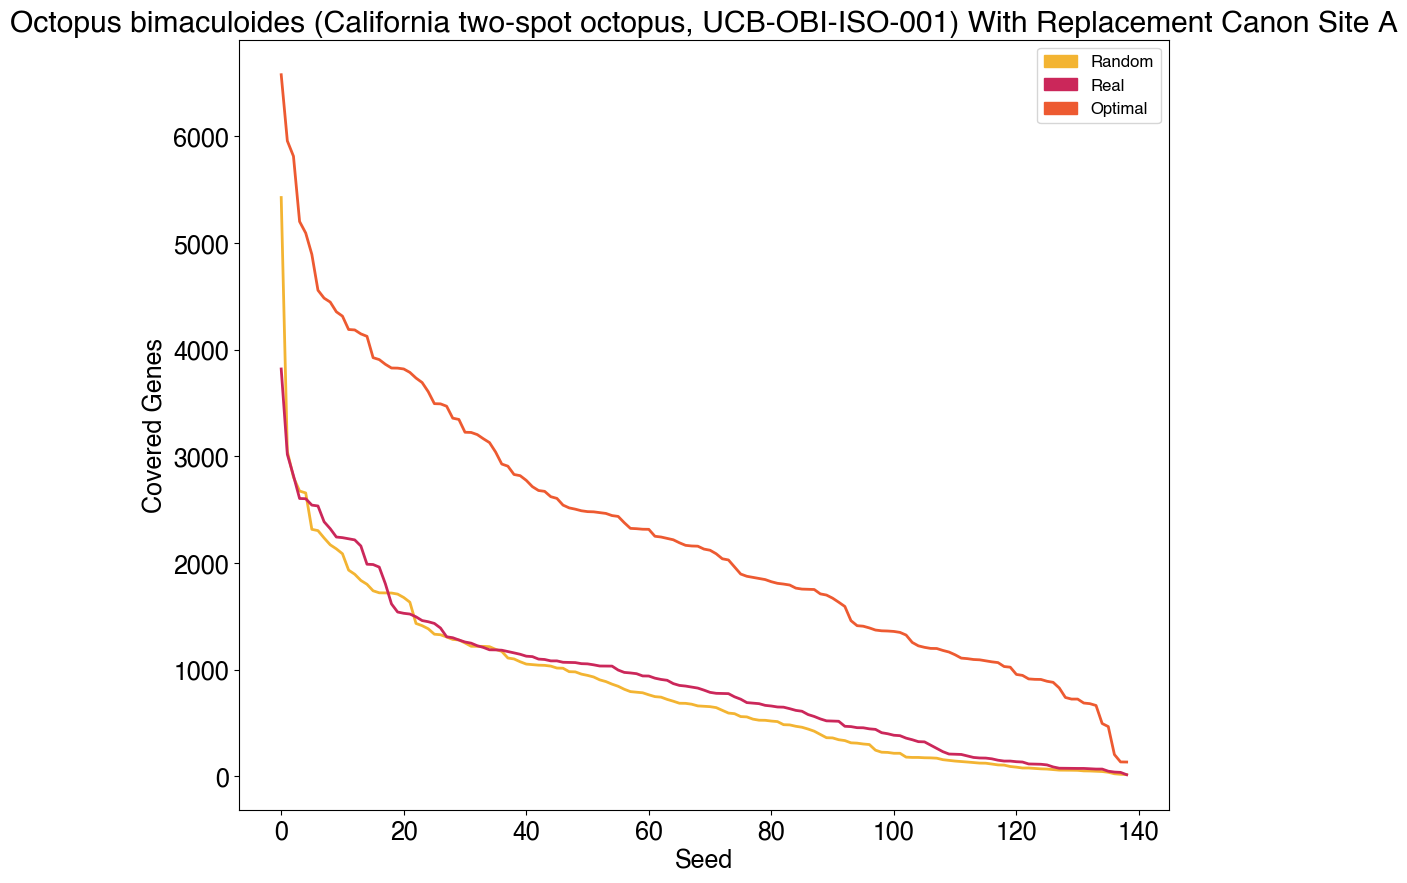

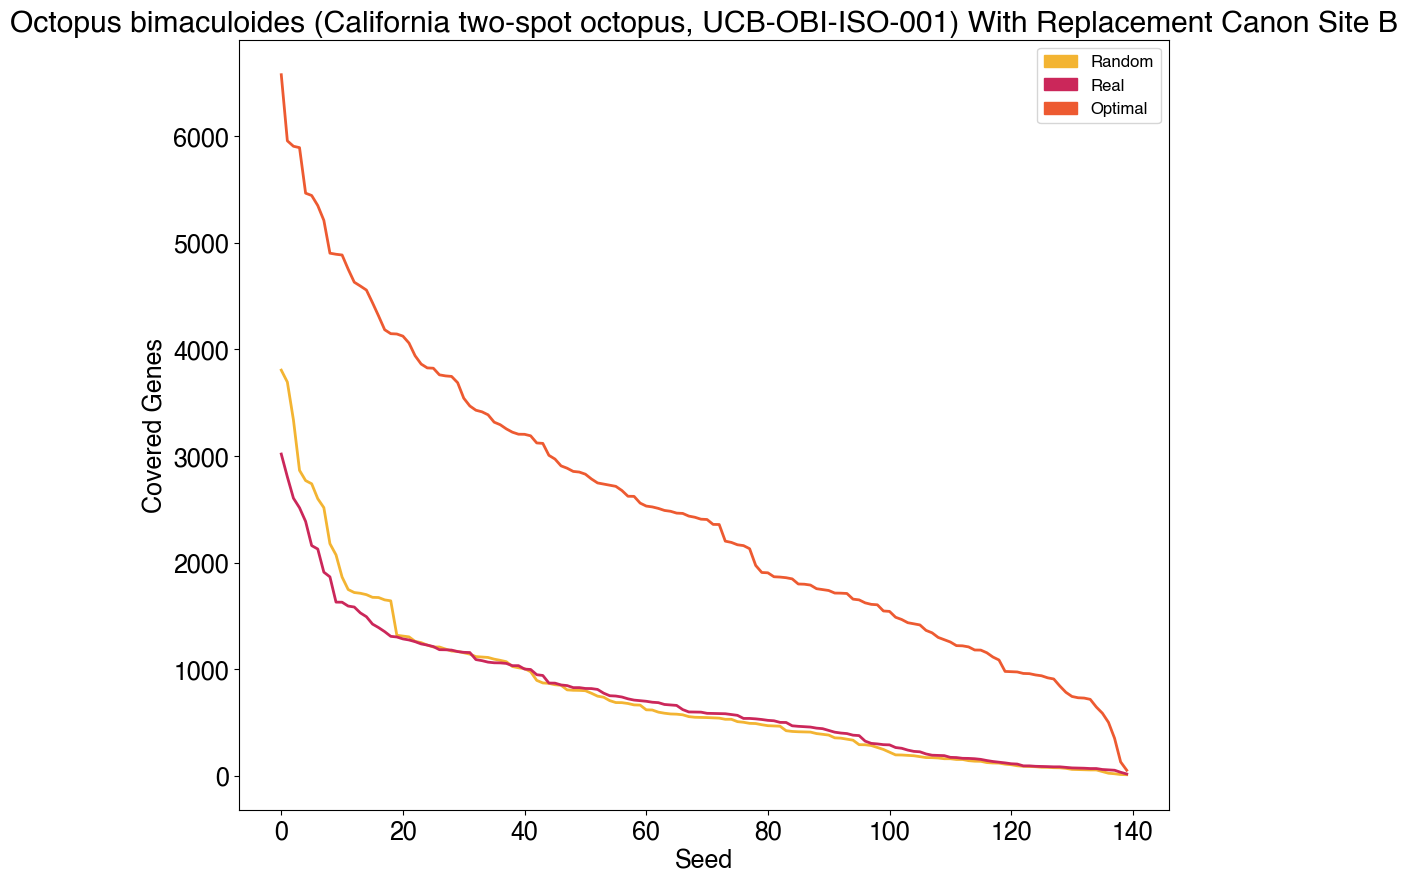

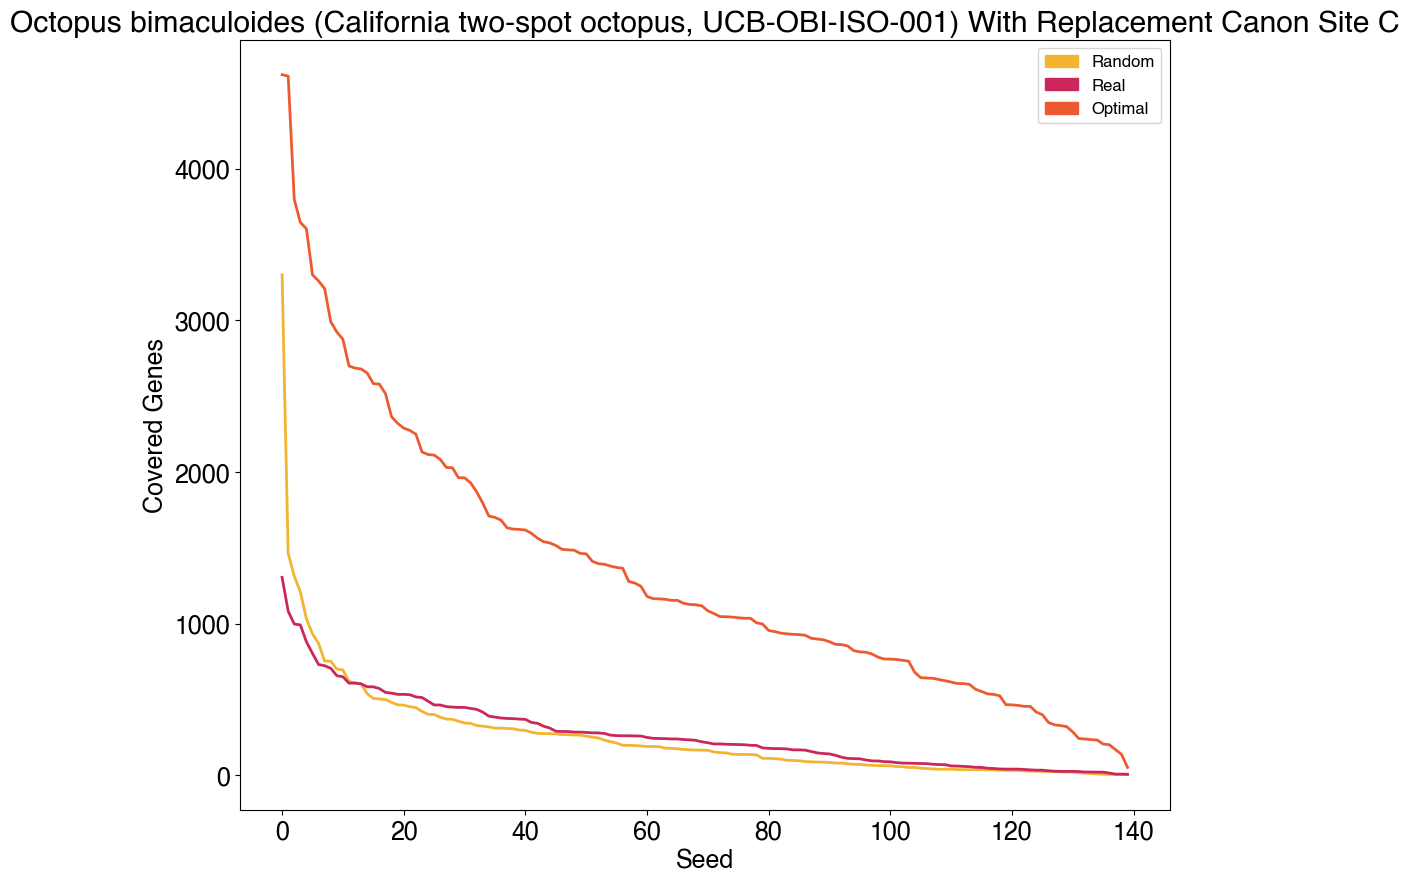

In [12]:
sites = ['A','B','C']
for species in species_list:
    for site in sites:
        plot_seed_rank(species[0],species[1],site, True)